## Treinamento com a VGG 16

### Import de bibliotecas principais

In [20]:
import torch
import torch.nn as nn
import numpy as np
import os
import numpy as np
import torch
import pickle
from PIL import Image
import glob
#from vision.references.detection import transforms as T   # torchvision.transforms as T
from torchvision import datasets, transforms
from PIL import ImageFilter
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Load de dataset

In [2]:
'''
Função para salvar estrutura de dados
em extensão .pckl para posterior uso
'''
def save_data(data, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)

'''
Função para carregar estrutura de dados
salva em extensão .pckl
'''
def load_data(data_path):
    with open(data_path, 'rb') as f:
        return pickle.load(f)

In [3]:
# Transformação para tensor, resize
# crop e normalização das imagens
def get_transform():
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

# Obtém o dataloader a partir de uma pasta
# Para testar o método, inicialmente treinei com duas classes, apenas. 
# Infelizmente, não tive tempo de otimizar o método para
# prosseguir com as demais classes
dataset = datasets.ImageFolder(
    root='dataset/temp/',
    transform=get_transform()
)

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

datasets = train_val_dataset(dataset)

data_loader_train = DataLoader(datasets['train'], batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
data_loader_test = DataLoader(datasets['val'], batch_size=1, shuffle=True, num_workers=4, pin_memory=True) #

### Montagem do modelo

In [5]:
# Obtém VGG 16 pretreinada do ImageNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

# Obtém somente a camada de encoding
new_model = model.features 
new_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Extração de features usando VGG 16

In [6]:
device = torch.device('cuda')
model = new_model.to(device)

# Para cada imagem do data loader,
# obtém as features correspondentes
_data=[]
_label=[]
for i, (data, label) in enumerate(data_loader_train):
    data, label = data.to(device), label.to(device)
    pred_speed = model(data)
    _data.append(list(pred_speed.reshape([1, 25088]).cpu().detach().numpy()[0]))
    _label.append(label.cpu().detach().numpy()[0])

In [ ]:
#salvar features
save_data(_data, './dataset/_data_vgg.pkl')
#save_data(_label, './dataset/_label_vgg.pkl')

In [7]:
device = torch.device('cuda')
model = new_model.to(device)

# Para cada imagem do data loader,
# obtém as features correspondentes
_data_test=[]
_label_test=[]
for i, (data, label) in enumerate(data_loader_test):
    data, label = data.to(device), label.to(device)
    pred_speed = model(data)
    _data_test.append(list(pred_speed.reshape([1, 25088]).cpu().detach().numpy()[0]))
    _label_test.append(label.cpu().detach().numpy()[0])

## Treinamento a partir das features da VGG

### Métricas de avaliação

Maior precision significa que o modelo retorna resultados mais relevantes do que inrelevantes, enquanto que maior recall significa que o modelo retorna a maioria dos resultados relevantes. F1-score combina a precisão e o reccal em uma unica métrica. É basicamente uma média "harmônica" entre a precision e o recall. A matriz de confusão sumariza a performace do modelo. Das redes treinadas abaixo, a SVM foi que obteve o melhor resultado, sendo apenas 16 amostras de gato apontadas erronemanete como cachorro e 13 de cachorros apontadas erroneamente como gatos.

---------
 0 - gato;
 1 - cachorro

### Treinamento SVM

In [8]:
clf=LinearSVC(max_iter=10000)#80000
clf.fit(_data,_label)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Pecision, Recall, F1-Score

In [11]:
predictions_svm = clf.predict(_data_test)
print(classification_report(_label_test, predictions_svm))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       504
           1       0.98      0.98      0.98       661

    accuracy                           0.98      1165
   macro avg       0.97      0.97      0.97      1165
weighted avg       0.98      0.98      0.98      1165



### Matriz de confusão

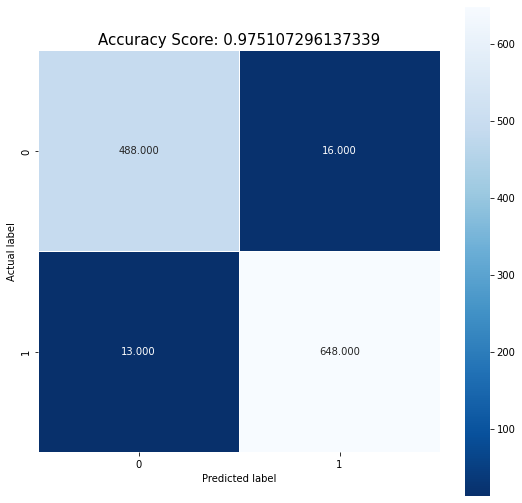

In [12]:
import seaborn as sns

acc_svm = accuracy_score(_label_test, predictions_svm)
predictions_svm = clf.predict(_data_test)
cm = confusion_matrix(_label_test, predictions_svm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

# Treinamento KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(_data,_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
predictions_knn = model.predict(_data_test)

### Pecision, Recall, F1-Score

In [16]:
print(classification_report(_label_test, predictions_knn))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       504
           1       0.96      0.89      0.92       661

    accuracy                           0.92      1165
   macro avg       0.91      0.92      0.91      1165
weighted avg       0.92      0.92      0.92      1165



### Matriz de confusão

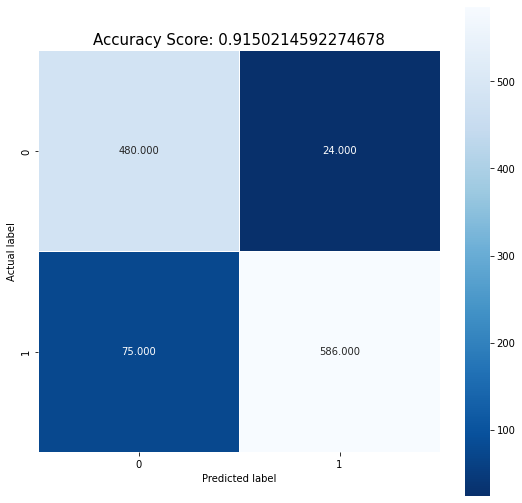

In [17]:
import seaborn as sns

acc_svm = accuracy_score(_label_test, predictions_knn)
cm = confusion_matrix(_label_test, predictions_knn)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

# Treinamento Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver='liblinear')
logisticRegr.fit(_data, _label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
predictions_lr = model.predict(_data_test)

### Pecision, Recall, F1-Score

In [25]:
print(classification_report(_label_test,predictions_lr))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       504
           1       0.96      0.89      0.92       661

    accuracy                           0.92      1165
   macro avg       0.91      0.92      0.91      1165
weighted avg       0.92      0.92      0.92      1165



### Matriz de confusão

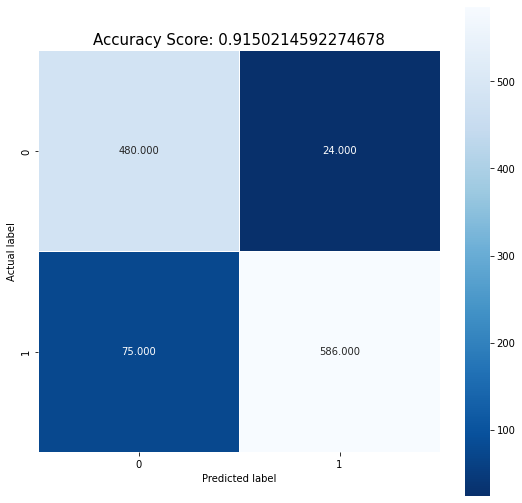

In [26]:
import seaborn as sns

acc_svm = accuracy_score(_label_test, predictions_lr)
cm = confusion_matrix(_label_test, predictions_lr)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);